In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy

In [4]:
# Open LC
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/ISAM_HYDE_LANDCOVER_1980.nc'
nclu_obs=NetCDFFile(path,'r')
lc = nclu_obs.variables['AREAVEG'][:]
latnc = nclu_obs.variables['latitude'][:]
lonnc = nclu_obs.variables['longitude'][:]
nclu_obs.close()
lc_forest = lc[0,:,:] + lc[1,:,:] + lc[2,:,:] + lc[3,:,:] + lc[4,:,:] + lc[5,:,:] + \
      lc[6,:,:] + lc[15,:,:] + lc[16,:,:] + lc[17,:,:] + lc[18,:,:] + lc[19,:,:] + \
      lc[20,:,:] + lc[21,:,:]
lc_tundra = lc[12,:,:]
lc_grass = lc[7,:,:] + lc[8,:,:] + lc[9,:,:] + lc[10,:,:] + lc[11,:,:] + lc[23,:,:] + lc[24,:,:] + lc[25,:,:] + lc[26,:,:]
lc_other = lc[13,:,:] + lc[14,:,:] + lc[22,:,:] + lc[27,:,:]
lc_storage = copy.deepcopy(lc[0:4,:,:])
lc_storage[0,:,:] = copy.deepcopy(lc_forest)
lc_storage[1,:,:] = copy.deepcopy(lc_tundra)
lc_storage[2,:,:] = copy.deepcopy(lc_grass)
lc_storage[3,:,:] = copy.deepcopy(lc_other)

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)


In [ ]:
plt.imshow(another_mask)

In [9]:
# Mask all regions outside the northern permafrost extent
lc_forest_perm = copy.deepcopy(lc_forest)
lc_forest_perm.mask = another_mask.mask
lc_tundra_perm = copy.deepcopy(lc_tundra)
lc_tundra_perm.mask = another_mask.mask
lc_grass_perm = copy.deepcopy(lc_grass)
lc_grass_perm.mask = another_mask.mask
lc_other_perm = copy.deepcopy(lc_other)
lc_other_perm.mask = another_mask.mask

lc_dominant = copy.deepcopy(lc_forest)

# Get the grid area
nlon = 720
nlat = 360
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        lc_dominant[i,j] = np.argmax(lc_storage[:,i,j])

lc_dominant.mask = another_mask.mask

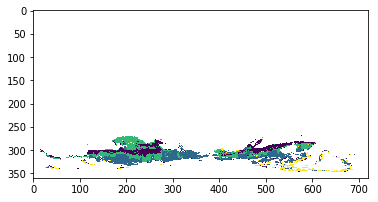

In [11]:
plt.imshow(lc_dominant)

In [40]:
126.0/255.0

0.49411764705882355

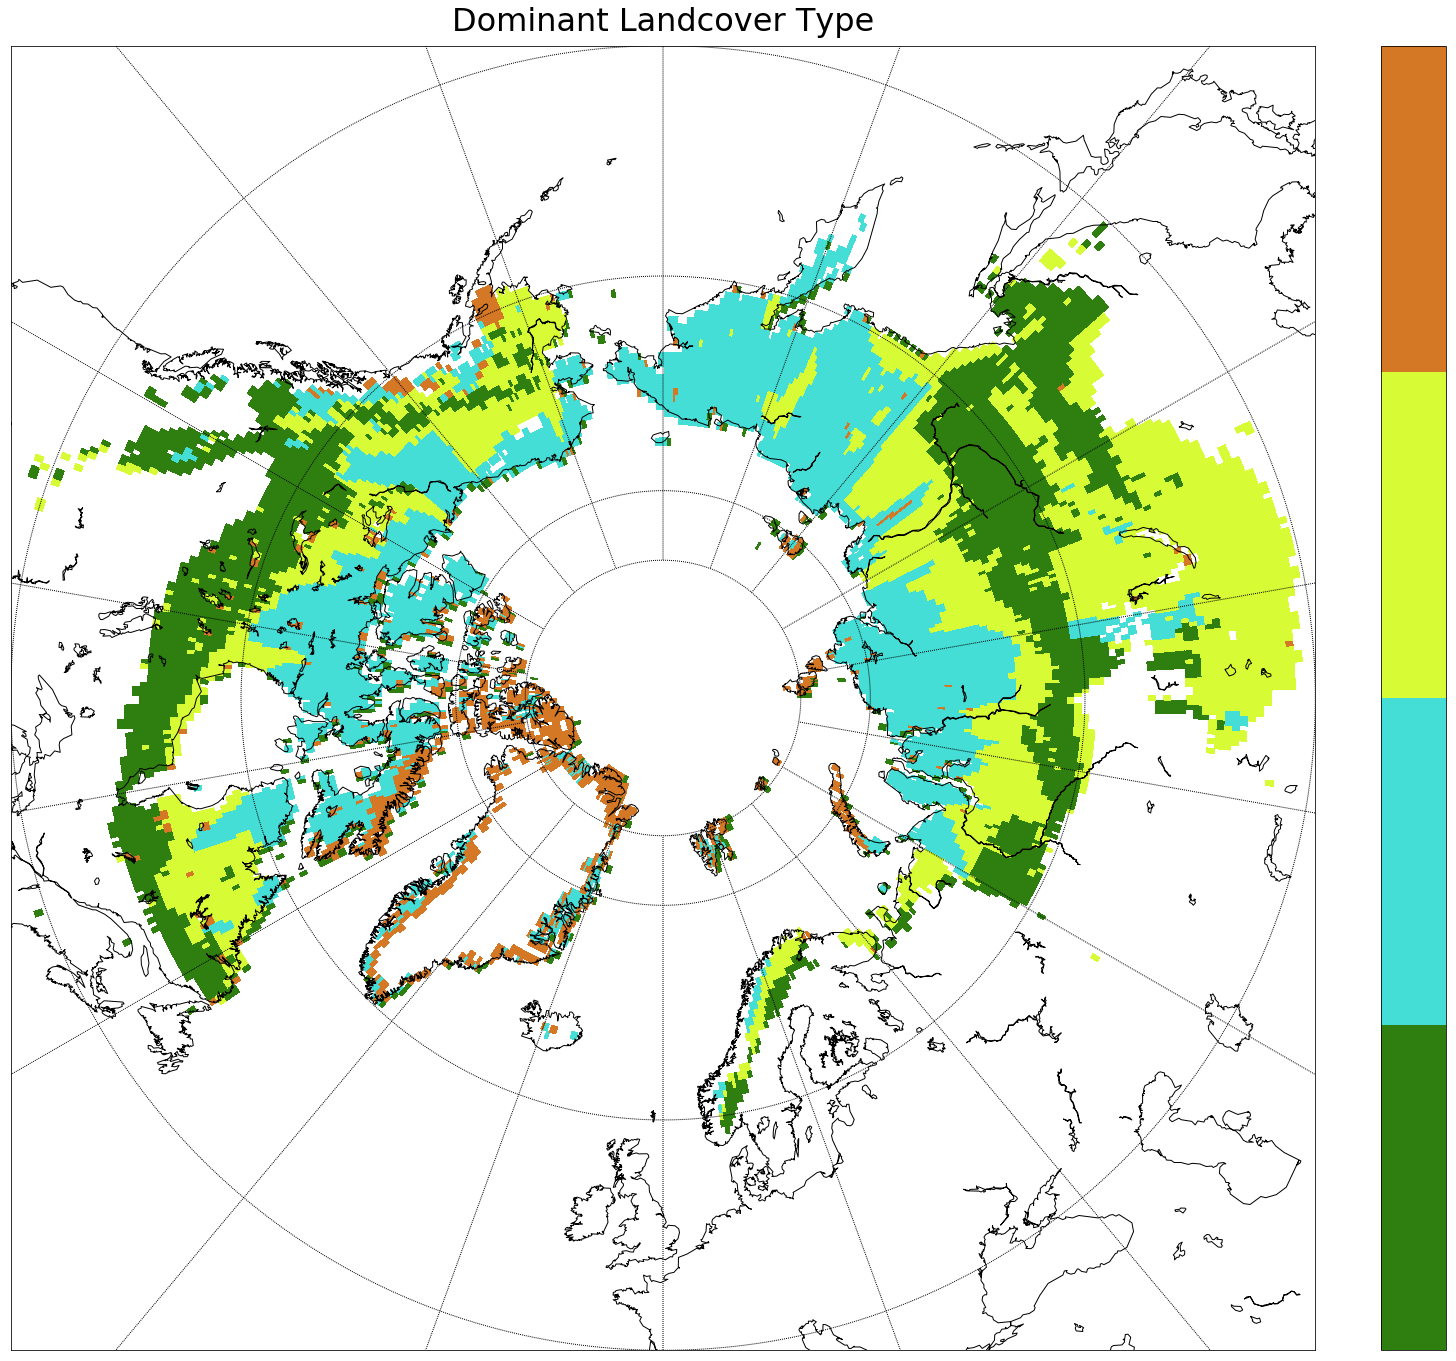

In [51]:
# Plot the figure1
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(30,24))

ax1 = fig.add_subplot(111)
ax1.set_title("Dominant Landcover Type",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
#map.fillcontinents(color='aliceblue',lake_color='aqua',zorder=0)
map.drawparallels(np.arange(45.,90.,15.))
map.drawmeridians(np.arange(-180.,180.,20.))
#map.drawmapboundary(fill_color='aqua')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc, latnc)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))

# Create new cmap for permafrost
cmap_name = 'LC'
colors = [(0.181, 0.494, 0.063), (0.267, 0.87, 0.84), (0.843, 0.984, 0.208), (0.835, 0.471, 0.149)]
n_bin = 4
newcm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

#djet.set_bad('white',1.)

# cs1 = map.contourf(x,y,mdata,clevs,cmap=plt.cm.jet)
# cs1 = map.contourf(x,y,ncvar_maize[:,:], [100], colors="black")
cs = map.pcolormesh(x,y,lc_dominant[:,:], cmap=newcm, edgecolors = 'None') # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='right',pad="5%",ticks=None,extend='neither')
#plt.title('Maize harvested area fraction')
cbar.set_ticks([])
#cbar.ax.set_xticklabels(['', '', '', '', '', ''])
#cbar.ax.tick_params(labelsize=18) 
#cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')

#map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
#map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.tick_params(labelsize=30) 

#plt.show()
plt.savefig('./figures/figS7.png',dpi=300)

In [ ]:
plt.imshow(soc_contemp_perm)

In [ ]:
soc_contemp_perm = copy.deepcopy(soc_contemp)

In [ ]:
plt.imshow(dsoc)

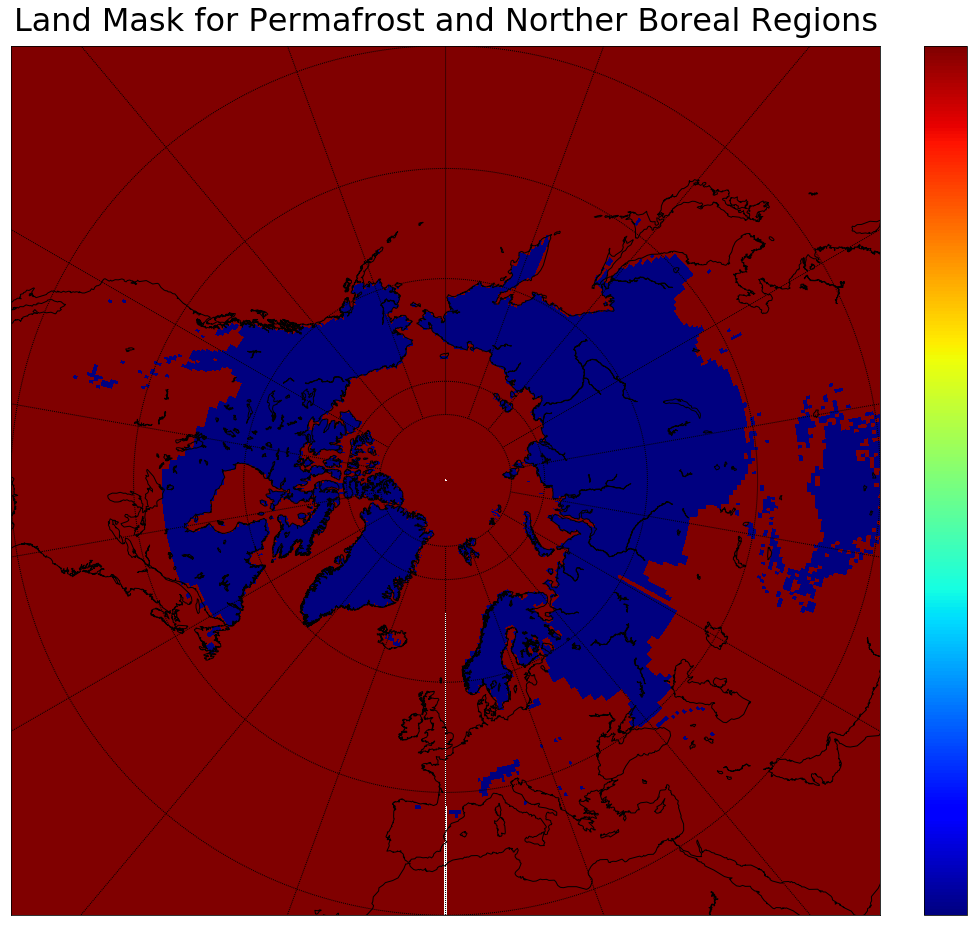

In [8]:
# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

fig = plt.figure(figsize=(20,16))
# Plot the figure S6, Dave McGuire's regional mask
ax1 = fig.add_subplot(111)
ax1.set_title("Land Mask for Permafrost and Norther Boreal Regions",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=30,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawparallels(np.arange(30.,90.,15.))
map.drawmeridians(np.arange(-180.,180.,20.))
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc, latnc)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))

# # Create new cmap for permafrost
# cmap_name = 'LC'
# colors = [(0.181, 0.494, 0.063), (0.267, 0.87, 0.84), (0.843, 0.984, 0.208), (0.835, 0.471, 0.149)]
# n_bin = 4
# newcm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

#djet.set_bad('white',1.)

# cs1 = map.contourf(x,y,mdata,clevs,cmap=plt.cm.jet)
# cs1 = map.contourf(x,y,ncvar_maize[:,:], [100], colors="black")
cs = map.pcolormesh(x,y,dv_msk[:,:], cmap=plt.cm.jet, edgecolors = 'None') # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='right',pad="5%",ticks=None,extend='neither')
#plt.title('Maize harvested area fraction')
cbar.set_ticks([])
#cbar.ax.set_xticklabels(['', '', '', '', '', ''])
#cbar.ax.tick_params(labelsize=18) 
#cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')

#map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
#map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.tick_params(labelsize=30) 

plt.show()
#plt.savefig('./figures/figs6.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

#plt.show()
plt.savefig('./figures/fig8.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig9.jpg',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
